In [311]:
import numpy as np  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import random
import math as m
import pandas as pd

In [312]:
NUM_INTERVALS = 96

In [313]:
NUM_ITERATIONS = 10_000
NUM_WOLFS = 200

In [314]:
def insert_travels_in_cars_state(cars_state, travels):
    cars_state_copy = cars_state.copy()
    cars_state_copy = list(cars_state_copy)
    for i, car_travels in enumerate(travels):
        for travel in car_travels:
            start, end = travel
            position = start + 96 * i
            cars_state_copy[position:position] = [0] * (end - start + 1)

    return cars_state_copy

In [315]:
def split_list(lst, chunk_size=NUM_INTERVALS):
    return [lst[i : i + chunk_size] for i in range(0, len(lst), chunk_size)]

In [316]:
def calculate_car_power(car_states, car):
    car_power = []
    for state in car_states:
        if state == 1:
            car_power.append(car["tx_charge"])
        elif state == -1:
            car_power.append(-car["tx_discharge"])
        else:
            car_power.append(0)

    return car_power

In [317]:
def cost_function(sample, travels, cars, generated_power, products_demand, energy_cost):
    cars_state_with_travels = insert_travels_in_cars_state(sample, travels)
    separated_cars_state = split_list(cars_state_with_travels)
    cars_power = [
        calculate_car_power(car_states, car)
        for car_states, car in zip(separated_cars_state, cars)
    ]
    total_cars_power = np.sum(cars_power, axis=0)
    total_liquid_power = generated_power - products_demand - total_cars_power
    money_in_time = total_liquid_power * energy_cost
    total_money_cost = np.sum(money_in_time)

    return -total_money_cost.tolist()

In [318]:
def generate_min_charging_random_vector(
    total_size, min_charging, car, energy_remaining
):
    vector = []
    car_battery = energy_remaining
    is_charged = False

    for i in range(total_size):
        if car_battery - (car["tx_discharge"] * (total_size - 1 - i)) >= 0:
            choice = -1
        elif car_battery - car["tx_discharge"] >= 0 and not is_charged:
            choice = random.choice([-1, 1])
        elif car_battery - car["tx_discharge"] >= 0:
            choice = -1
        elif not is_charged:
            choice = 1

        vector_aux = vector.copy()
        vector_aux.append(choice)
        vector_aux.append((total_size - i - 1) * [1])
        chargings = vector_aux.count(1)
        dischargings = vector_aux.count(-1)

        if (
            energy_remaining
            + chargings * car["tx_charge"]
            - dischargings * car["tx_discharge"]
            < min_charging * car["tx_charge"]
        ):
            choice = 1

        if choice == -1:
            car_battery -= car["tx_discharge"]
            is_charged = False
        else:
            car_battery += car["tx_charge"]

        if car_battery >= car["autonomy_kwh"]:
            car_battery = car["autonomy_kwh"]
            is_charged = True

        vector.append(choice)

    return vector, car_battery

In [319]:
def generate_cars_state(charge_times, available_intervals, cars, travels):
    final_states = []

    for charge_time, car_available_intervals, car, car_travels in zip(
        charge_times, available_intervals, cars, travels
    ):
        energy_remaining = 0
        for (start, end), min_charge, travel in zip(
            car_available_intervals, charge_time, [*car_travels, (0, 0)]
        ):
            available_list, energy_remaining = generate_min_charging_random_vector(
                end - start + 1, min_charge, car, energy_remaining
            )
            energy_remaining -= (travel[1] - travel[0] + 1) * car["tx_discharge"]
            final_states.extend(available_list)

    return final_states

In [320]:
def find_available_intervals(occupied_positions):
    available_intervals = []
    current_start = 0

    for start, end in sorted(occupied_positions):
        if current_start < start:
            available_intervals.append((current_start, start - 1))
        current_start = end + 1

    if current_start < NUM_INTERVALS:
        available_intervals.append((current_start, NUM_INTERVALS - 1))

    return available_intervals

In [321]:
def calculate_travel_charge_time(travel, tx_charge, tx_discharge):
    start, end = travel
    spent_energy = (end - start + 1) * tx_discharge
    charge_time = m.ceil(spent_energy / tx_charge)

    return charge_time

In [322]:
def calculate_charge_times(available_intervals, travels, cars):
    return [
        [
            calculate_travel_charge_time(travel, car["tx_charge"], car["tx_discharge"])
            for travel in car_travels
        ]
        + [0] * (len(available_interval) - len(car_travels))
        for car, car_travels, available_interval in zip(
            cars.copy(), travels.copy(), available_intervals.copy()
        )
    ]

In [323]:
def preencher_vetores_interpolacao(your_existing_data, size_wanted):
    # Your existing data with 1000 values
    existing_data = your_existing_data  # Replace with your data

    # Desired number of positions
    desired_length = size_wanted

    # Create a new array to hold the interpolated data
    interpolated_data = np.zeros(desired_length)

    # Calculate the number of intervals between existing data points
    num_intervals = len(existing_data) - 1

    # Calculate the step size to insert between existing data points
    step_size = 1 / (num_intervals + 1)

    # Loop through the existing data points and interpolate values
    for i in range(num_intervals):
        start_index = int((i * desired_length) / num_intervals)
        end_index = int(((i + 1) * desired_length) / num_intervals)

        # Linear interpolation between existing_data[i] and existing_data[i+1]
        interpolated_data[start_index:end_index] = np.linspace(
            existing_data[i], existing_data[i + 1], end_index - start_index
        )

    # Fill the remaining positions with the last value in existing_data
    interpolated_data[end_index + 1 :] = existing_data[-1]

    return interpolated_data

In [324]:
def PotGD():
    """
    Calcula a potência gerada pela GD (gerador distribuído) em um quarto de dia (24 horas).

    Retorna:
        potenciaGeradaQuarter: vetor com a potência gerada a cada 15 minutos (num_intervals valores).
    """

    # Leitura de dados meteorológicos
    dados_met = pd.read_csv("./DadosMeterologicos2024.csv", delimiter=";", header=0)

    # Conversão da tabela em matriz
    dados_met = dados_met.to_numpy()

    # Parâmetros do aerogerador VERNE 555
    vel_corte_entrada = 2.2
    vel_corte_saida = 16

    # Velocidades e potências do aerogerador
    velocidades = [2.2, 6, 7.1, 8.2, 9, 9.7, 10.5, 10.8, 13.8, 16]
    potencias = [0, 1, 2, 3, 4, 5, 6, 6.5, 7, 6.7]

    # Coeficientes da polinômia de ajuste
    coeficientes = np.polyfit(velocidades, potencias, 5)

    # Número de linhas da tabela de dados meteorológicos
    num_linhas = dados_met.shape[0]

    # Cálculo da potência do aerogerador por hora
    potencia_aero = np.zeros(num_linhas)
    for i in range(num_linhas):

        if dados_met[i, 2] >= vel_corte_entrada and dados_met[i, 2] <= vel_corte_saida:
            # Cálculo da potência usando a polinômia de ajuste
            potencia_aero[i] = (
                coeficientes[0] * dados_met[i, 2] ** 5
                + coeficientes[1] * dados_met[i, 2] ** 4
                + coeficientes[2] * dados_met[i, 2] ** 3
                + coeficientes[3] * dados_met[i, 2] ** 2
                + coeficientes[4] * dados_met[i, 2]
                + coeficientes[5]
            )
        elif dados_met[i, 2] > vel_corte_saida:
            # Potência máxima do aerogerador
            potencia_aero[i] = 6.7
        else:
            # Potência zero
            potencia_aero[i] = 0

        # Correção para valores negativos (erro de arredondamento)
        if potencia_aero[i] < 0:
            potencia_aero[i] = 0

    # Conversão para kW
    potencia_aero *= 1000

    # Cálculo da potência gerada pelos painéis fotovoltaicos (modelo 4 CS3Y 500ms)
    num_paineis = 1  # Número de painéis
    temp_nominal = 42  # Temperatura nominal de operação da célula (oC)
    isc = 11.77  # Corrente de curto circuito da célula (A)
    ki = 0.05  # Coeficiente de corrente/temperatura (A/oC)
    voc = 53.7  # Tensão de circuito aberto do módulo (V)
    kv = 0.26  # Coeficiente de tensão/temperatura (V/oC)
    vmppt = 45  # Tensão no ponto de máxima potência (V)
    imppt = 11.12  # Corrente no ponto de máxima potência (A)

    potencia_pv = np.zeros(num_linhas)

    for i in range(num_linhas):
        ta = dados_met[i, 1]
        r = dados_met[i, 0] / 3600
        tc = ta + r * (temp_nominal - 20) / 0.8
        i_pv = r * (isc + ki * (tc - 25))
        v_pv = voc - kv * (tc - 25)
        ff = (vmppt * imppt) / (voc * isc)
        potencia_pv[i] = num_paineis * ff * v_pv * i_pv

    # Combinação das potências
    pot = (2 * potencia_aero + 40 * potencia_pv) / 1000

    # Interpolação e ajuste dos valores
    potenciaGeradaQuarter = preencher_vetores_interpolacao(pot, NUM_INTERVALS) * 0.25

    for i in range(1, len(potenciaGeradaQuarter) - 1):
        if (
            potenciaGeradaQuarter[i - 1] > 0
            and potenciaGeradaQuarter[i + 1] > 0
            and potenciaGeradaQuarter[i] == 0
        ):
            potenciaGeradaQuarter[i] = (
                potenciaGeradaQuarter[i - 1] + potenciaGeradaQuarter[i + 1]
            ) / 2

    return potenciaGeradaQuarter

In [325]:
def calculate_products_demand():
    # horario que os produtos ficam prontos
    num_elementos = 30

    # Produção de entrega 4 até as 22
    horaProducao = 4 + (18 * np.random.rand(num_elementos, 1))

    # Inicializando a curva de demanda total dos produtos fabricados
    horaFinalProducao = horaProducao
    horaInicialProducao = horaProducao - 2

    # Número de intervalos de tempo em um dia (24 horas discretizadas em 15 minutos)
    numIntervalos = int(24 * 60 / 15)

    # Inicializando a curva de demanda total
    curvaDemandaTotal = np.zeros(numIntervalos)

    # Iterando sobre cada produto
    for i in range(len(horaProducao)):
        # Convertendo a hora inicial e final do produto em intervalos de 15 minutos
        inicioProduto = int(horaInicialProducao[i] * 4)
        finalProduto = int(horaFinalProducao[i] * 4)

        # Garantindo que o intervalo do produto esteja dentro dos limites do dia
        inicioProduto = max(1, inicioProduto)
        finalProduto = min(finalProduto, numIntervalos)

        # Adicionando a demanda do produto na curva de demanda total
        curvaDemandaTotal[inicioProduto:finalProduto] += 1

    # Calculando a potência total demandada (considerando que cada produto consome 4 kW)
    curvaDemandaTotal *= 4

    return curvaDemandaTotal


In [326]:
def calculate_energy_cost():
    foraponta = 0.46429 / 4  # R$/kWh
    intermediario = 0.69813 / 4  # R$/kWh
    ponta = 1.09716 / 4  # R$/kWh
    energy_cost = np.zeros(NUM_INTERVALS)

    # Divide o dia em intervalos e atribui o custo de energia correspondente a cada intervalo
    for i in range(NUM_INTERVALS):
        if 18 <= i / 4 < 19:
            energy_cost[i] = intermediario
        elif 19 <= i / 4 < 22:
            energy_cost[i] = ponta
        elif 22 <= i / 4 < 23:
            energy_cost[i] = intermediario
        else:
            energy_cost[i] = foraponta

    return energy_cost

In [327]:
def is_valid_providing_list(cars_state, car):
    car_energy = 0
    is_charged = False

    for state in cars_state:
        if state <= 0:
            car_energy -= car["tx_discharge"]
            is_charged = False
        else:
            car_energy += car["tx_charge"]

        if car_energy < 0:
            return False

        if car_energy >= car["autonomy_kwh"]:
            car_energy = car["autonomy_kwh"]
            is_charged = True

        if is_charged and state == 1:
            return False

    return True

In [328]:
def plot_linear(data, title, xlabel, ylabel):
    plt.figure(figsize=(22, 5))
    plt.plot(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [329]:
def plot_car_states(car_states):
    plt.figure(figsize=(22, 5))
    plt.scatter(range(len(car_states)), car_states, marker="o")
    plt.title("Car situation over time")
    plt.xlabel("15-minutes Interval")
    plt.ylabel("Situation")
    plt.grid(True)
    plt.yticks([-1, 0, 1])
    plt.ylim(-1.1, 1.1)
    plt.show()

In [330]:
def calculate_car_energy(car_states, car):
    car_energy = 0

    capacity_in_time = []

    for car_state in car_states:
        if car_state <= 0:
            car_energy -= car["tx_discharge"]
        else:
            car_energy = min(car_energy + car["tx_charge"], car["autonomy_kwh"])

        capacity_in_time.append(car_energy)

    return capacity_in_time

In [331]:
def generate_wolf(
    charge_times,
    available_intervals,
    cars,
    travels,
    generated_power,
    products_demand,
    energy_cost,
):
    position = generate_cars_state(charge_times, available_intervals, cars, travels)

    return {
        "position": position,
        "score": cost_function(
            position,
            travels,
            cars,
            generated_power,
            products_demand,
            energy_cost,
        ),
    }

In [332]:
def determine_leaders(wolfs):
    return sorted(wolfs, key=lambda x: x["score"])

In [333]:
def calculate_a(iteration):
    return 2 * (1 - iteration / (NUM_ITERATIONS - 1))

In [334]:
def calculate_distance(x_leader, x_omega, iteration):
    a = calculate_a(iteration)
    r1 = np.random.rand()
    r2 = np.random.rand()
    A = 2 * a * r1 - a
    C = 2 * r2
    D_leader = np.abs(C * np.array(x_leader) - np.array(x_omega))

    return D_leader, A

In [335]:
def update_position(
    wolfs,
    iteration,
    travels,
    cars,
    charge_times,
    available_intervals,
    generated_power,
    products_demand,
    energy_cost,
):
    wolfs_to_update = wolfs[3:]

    X_alpha = wolfs[0]["position"]
    X_beta = wolfs[1]["position"]
    X_delta = wolfs[2]["position"]

    for omega_wolf in wolfs_to_update:
        D_alpha, A_1 = calculate_distance(X_alpha, omega_wolf["position"], iteration)
        D_beta, A_2 = calculate_distance(X_beta, omega_wolf["position"], iteration)
        D_delta, A_3 = calculate_distance(X_delta, omega_wolf["position"], iteration)

        X_1 = X_alpha - A_1 * D_alpha
        X_2 = X_beta - A_2 * D_beta
        X_3 = X_delta - A_3 * D_delta

        omega_wolf["position"] = (X_1 + X_2 + X_3) / 3
        omega_wolf["position"] = np.where(omega_wolf["position"] < 0, -1, 1)

        cars_state_with_travels = insert_travels_in_cars_state(omega_wolf["position"], travels)
        separated_cars_state = split_list(cars_state_with_travels)

        for car_state, car in zip(separated_cars_state, cars):
            if not is_valid_providing_list(car_state, car):
                omega_wolf["position"] = generate_cars_state(
                    charge_times, available_intervals, cars, travels
                )
                break

        omega_wolf["score"] = cost_function(
            omega_wolf["position"],
            travels,
            cars,
            generated_power,
            products_demand,
            energy_cost,
        )

In [336]:
def plot(wolfs):
    # Obtendo os valores de posição como NumPy array
    positions = [wolf["score"] for wolf in wolfs]

    # Criando o gráfico com uma linha horizontal e pontos em positions
    plt.figure(figsize=(22, 4))
    plt.plot(
        positions,
        [0] * len(positions),
        marker="o",
        color="b",
        linestyle="",
        label="Pontos",
    )  # Plotando pontos em positions, eixo y fixado em zero
    plt.xlabel("Valor de X")  # Nomeando o eixo x
    plt.ylabel("Valor de Y")  # Nomeando o eixo y
    plt.title("Gráfico de Linha Unidimensional com Pontos")
    # plt.xlim(-100, 100)
    plt.legend()  # Mostrando a legenda
    plt.grid(True)  # Adicionando grade ao gráfico (opcional)
    plt.show()  # Exibindo o gráfico

In [337]:
cars = [
    {
        "autonomy_km": car[1],
        "autonomy_kwh": car[6],
        "tx_charge": np.abs((car[7] / 60) * 15),
        "tx_discharge": np.abs((car[8] / 60) * 15),
    }
    for car in [
        [1, 170, 1, 0, 0, 4, 44.9, 0.2 * 44.9, -50 / 4, (60 / 170) * 44.9 * 0.25],
        [2, 230, 2, 0, 0, 5, 229, 0.2 * 229, -100 / 4, (60 / 230) * 229 * 0.25],
        [3, 230, 3, 0, 0, 3, 174, 0.2 * 174, -100 / 4, (60 / 230) * 174 * 0.25],
    ]
]

In [338]:
travels = [[(15, 20), (48, 55), (90, 92)], [(17, 24), (90, 92)], [(50, 55), (76, 89)]]

In [339]:
available_intervals = [find_available_intervals(travel) for travel in travels]

In [340]:
charge_times = calculate_charge_times(available_intervals, travels, cars)

In [341]:
cars_state = generate_cars_state(charge_times, available_intervals, cars, travels)

In [342]:
generated_power = PotGD()

In [343]:
products_demand = calculate_products_demand()

/tmp/ipykernel_22055/1016038112.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inicioProduto = int(horaInicialProducao[i] * 4)
/tmp/ipykernel_22055/1016038112.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  finalProduto = int(horaFinalProducao[i] * 4)


In [344]:
energy_cost = calculate_energy_cost()

In [345]:
wolfs = [
    generate_wolf(
        charge_times,
        available_intervals,
        cars,
        travels,
        generated_power,
        products_demand,
        energy_cost,
    )
    for _ in range(NUM_WOLFS)
]

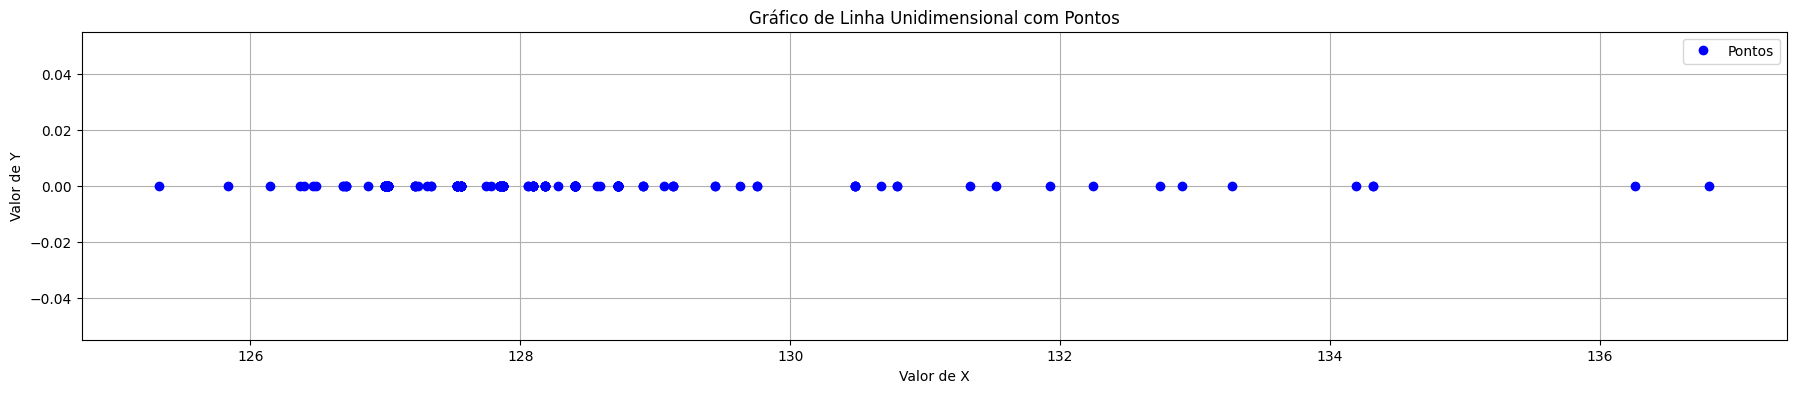

{'position': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1], 'score': 128.7215063758331}


In [346]:
plot(wolfs)
print(wolfs[0])

In [347]:
i = 0

history = []

while True:
    print(f"Iteration {i+1}")

    update_position(
        wolfs,
        i,
        travels,
        cars,
        charge_times,
        available_intervals,
        generated_power,
        products_demand,
        energy_cost,
    )
    wolfs = determine_leaders(wolfs)
    history.append(wolfs[0]["score"])

    i += 1

    if i == NUM_ITERATIONS:
        break

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6


Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteration 78
Iteration 79
Iteration 80
Iteration 81
Iteration 82
Iteration 83
It

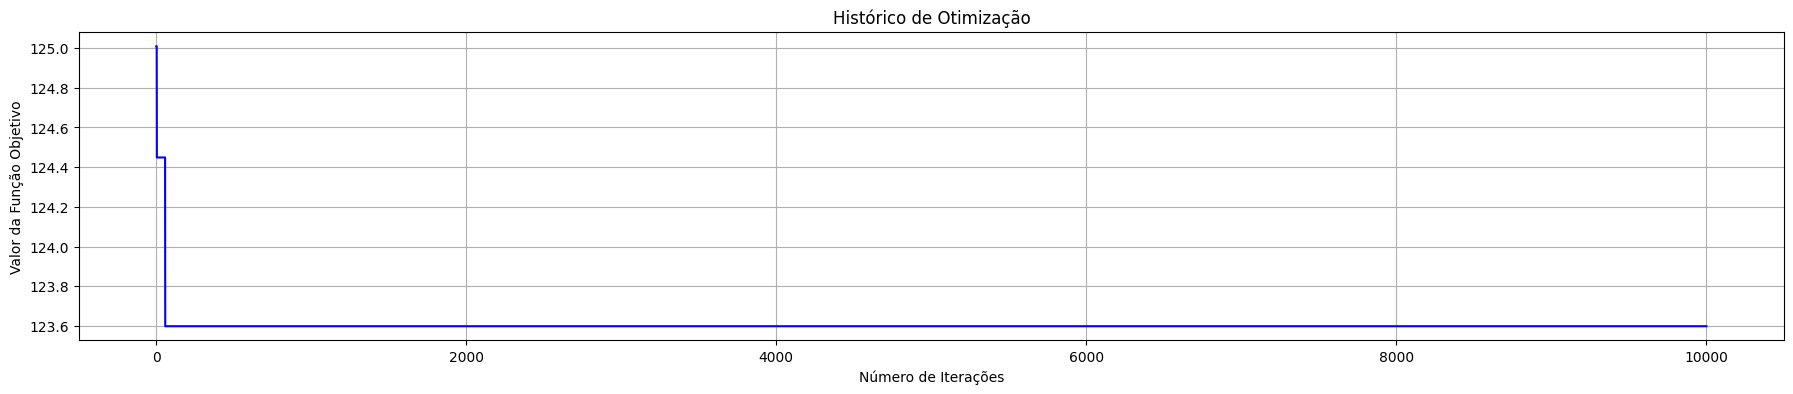

In [348]:
# Criação do gráfico
plt.figure(figsize=(22, 4))
plt.plot(
    range(1, NUM_ITERATIONS + 1), history, linestyle="-", color="b"
)

# Adicionando rótulos e título
plt.xlabel("Número de Iterações")
plt.ylabel("Valor da Função Objetivo")
plt.title("Histórico de Otimização")

# Exibindo o gráfico
plt.grid(True)
plt.show()

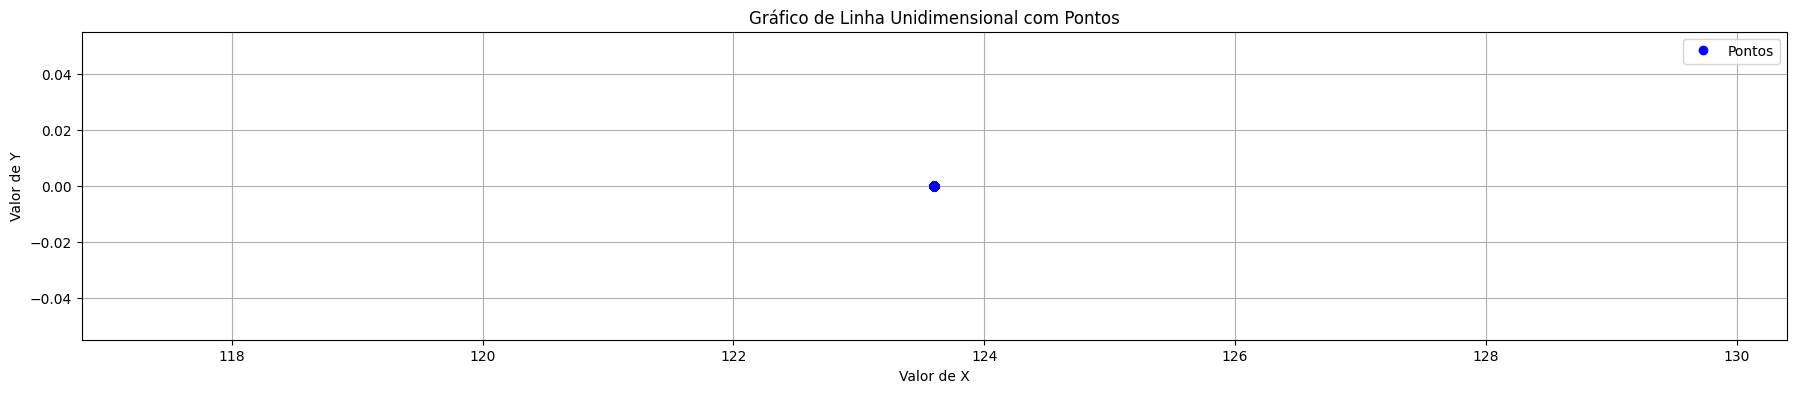

In [349]:
plot(wolfs)

In [350]:
print(wolfs[0])

{'position': array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1,
       -1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,
       -1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1,
       -1,  1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1, -1,  1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1, -1, -1,  1, -1,  1, -1,  1,  1, -1,  1,
       -1,  1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  

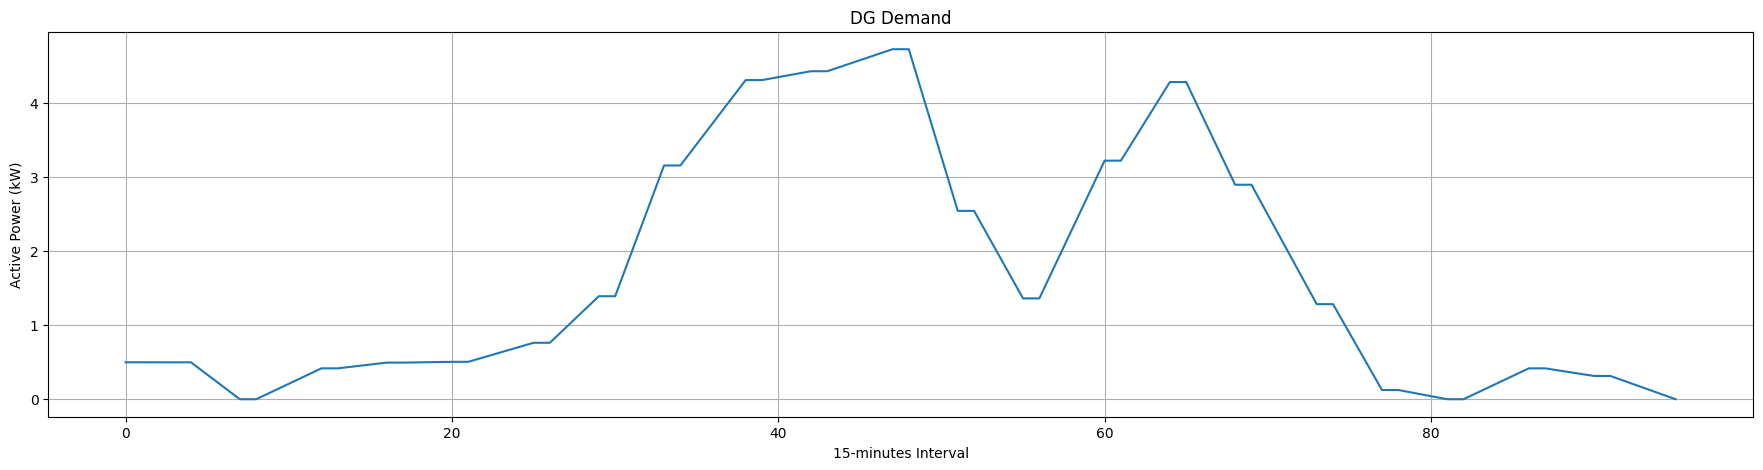

In [351]:
plot_linear(generated_power, "DG Demand", "15-minutes Interval", "Active Power (kW)")

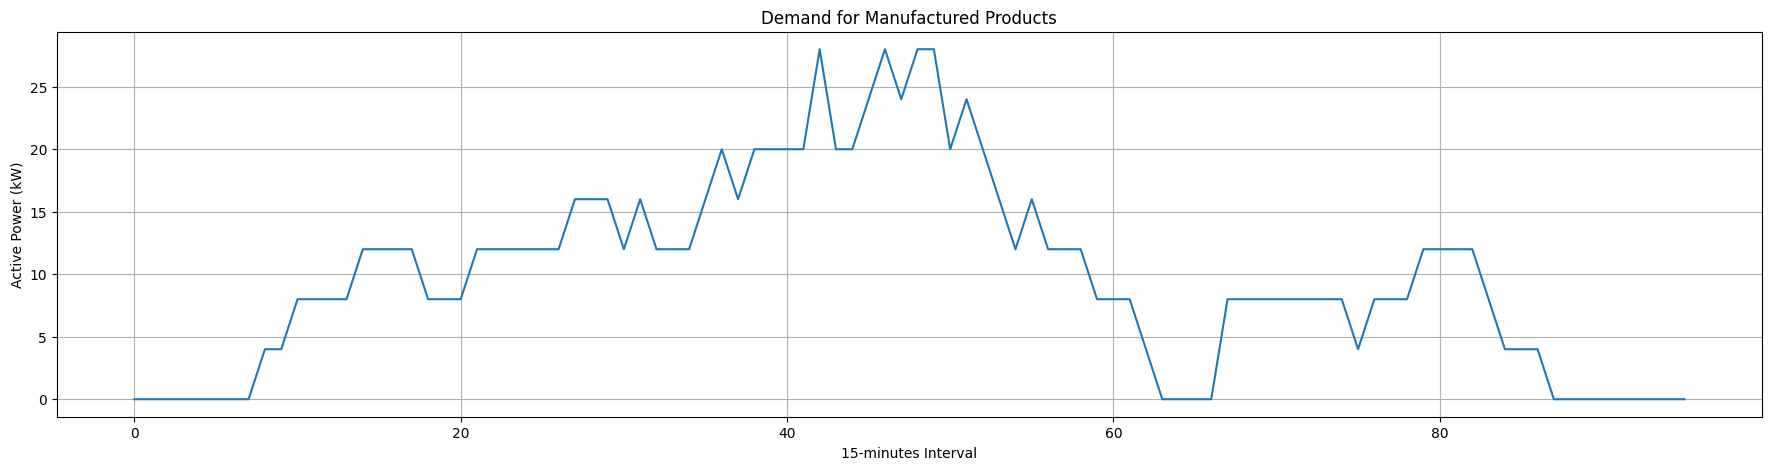

In [352]:
plot_linear(products_demand, "Demand for Manufactured Products", "15-minutes Interval", "Active Power (kW)")

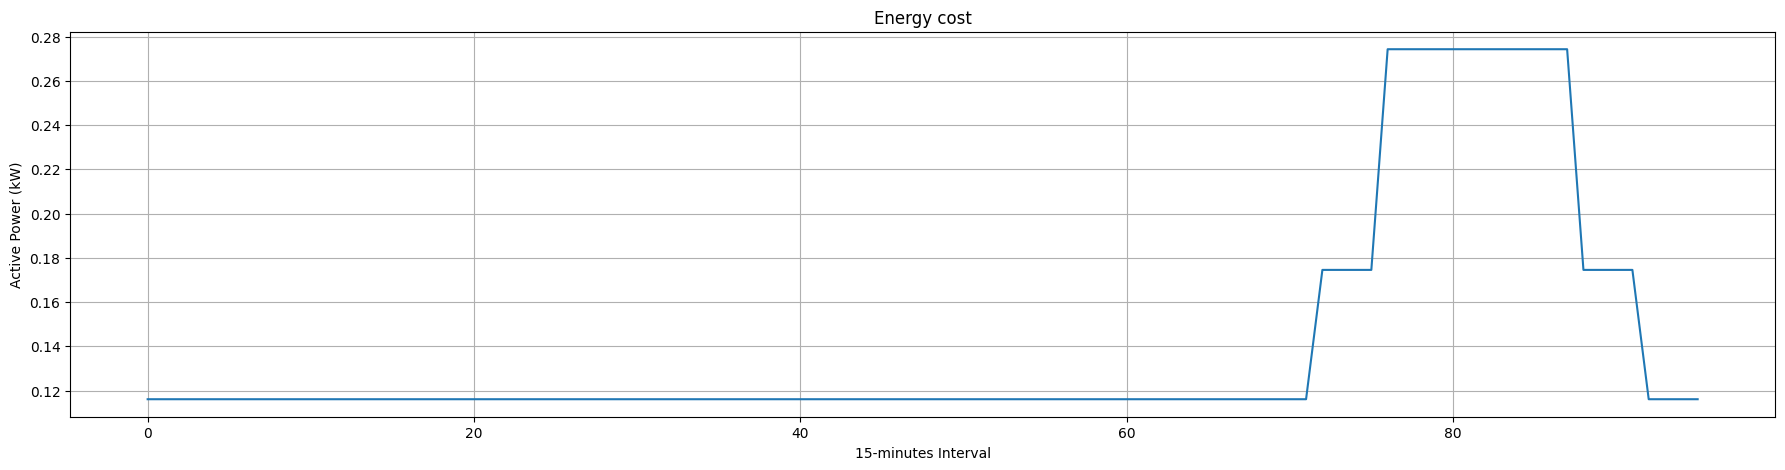

In [353]:
plot_linear(energy_cost, "Energy cost", "15-minutes Interval", "Active Power (kW)")

In [354]:
cars_state_with_travels = insert_travels_in_cars_state(wolfs[0]["position"], travels)
print(*cars_state_with_travels)
print(len(cars_state_with_travels))

1 1 1 1 1 1 1 1 1 1 1 -1 1 -1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 -1 1 1 1 -1 -1 1 -1 1 1 -1 1 -1 1 -1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 1 -1 1 0 0 0 -1 1 -1 1 1 1 1 1 1 -1 1 -1 -1 1 -1 -1 1 -1 -1 1 0 0 0 0 0 0 0 0 1 -1 1 -1 -1 1 -1 1 -1 1 1 -1 -1 -1 1 1 -1 1 1 -1 1 1 1 -1 1 1 1 1 -1 1 1 -1 1 -1 1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 1 0 0 0 -1 -1 -1 1 1 1 1 1 1 1 1 1 1 -1 1 1 -1 -1 1 -1 1 -1 1 1 -1 1 -1 1 -1 1 1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 1 -1 -1 1 -1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 -1 1 -1 1 -1 -1 1 -1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 1
288


In [355]:
separated_cars_state = split_list(cars_state_with_travels)

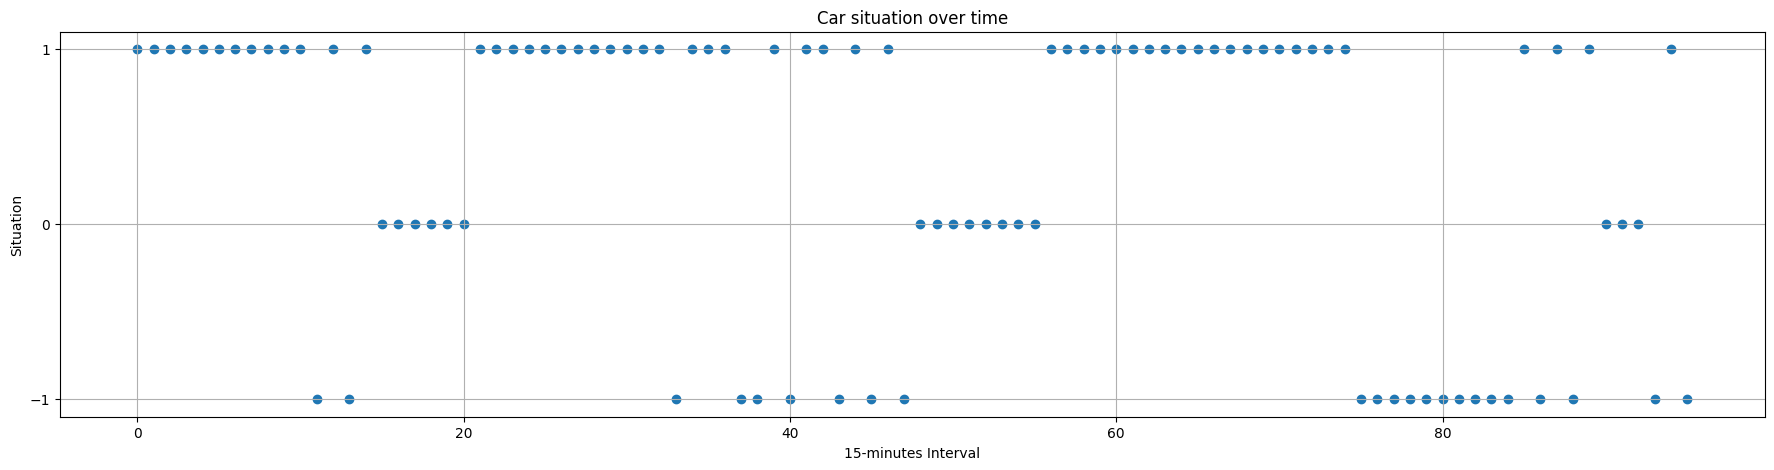

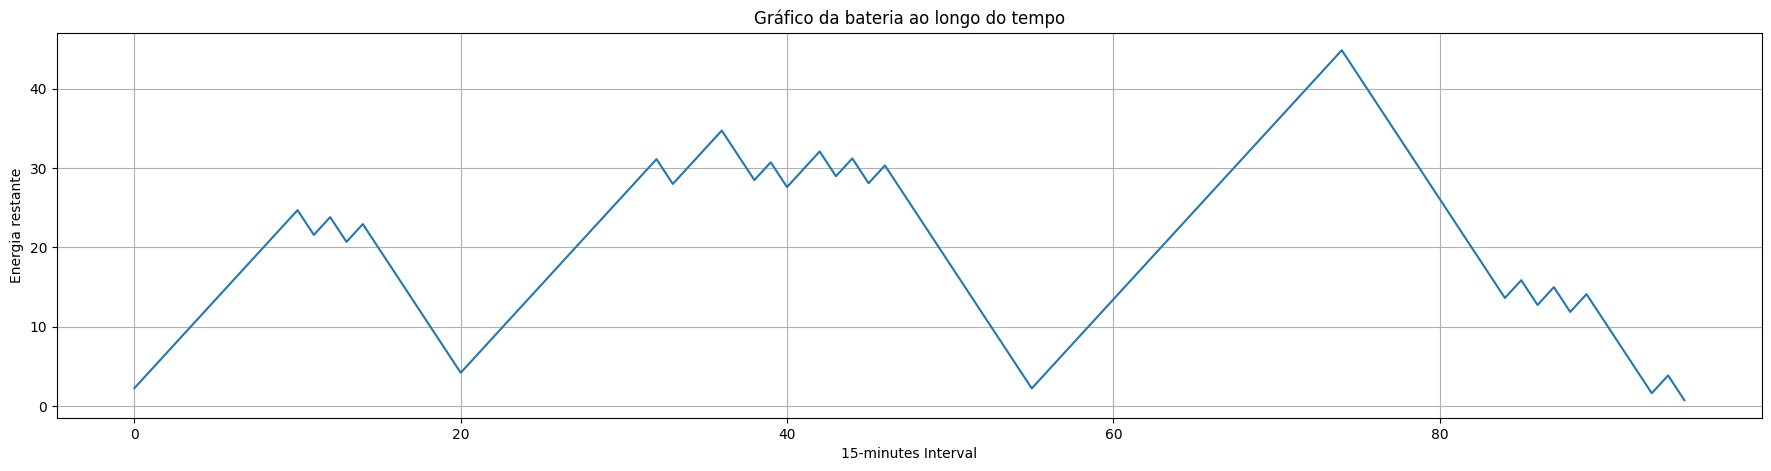

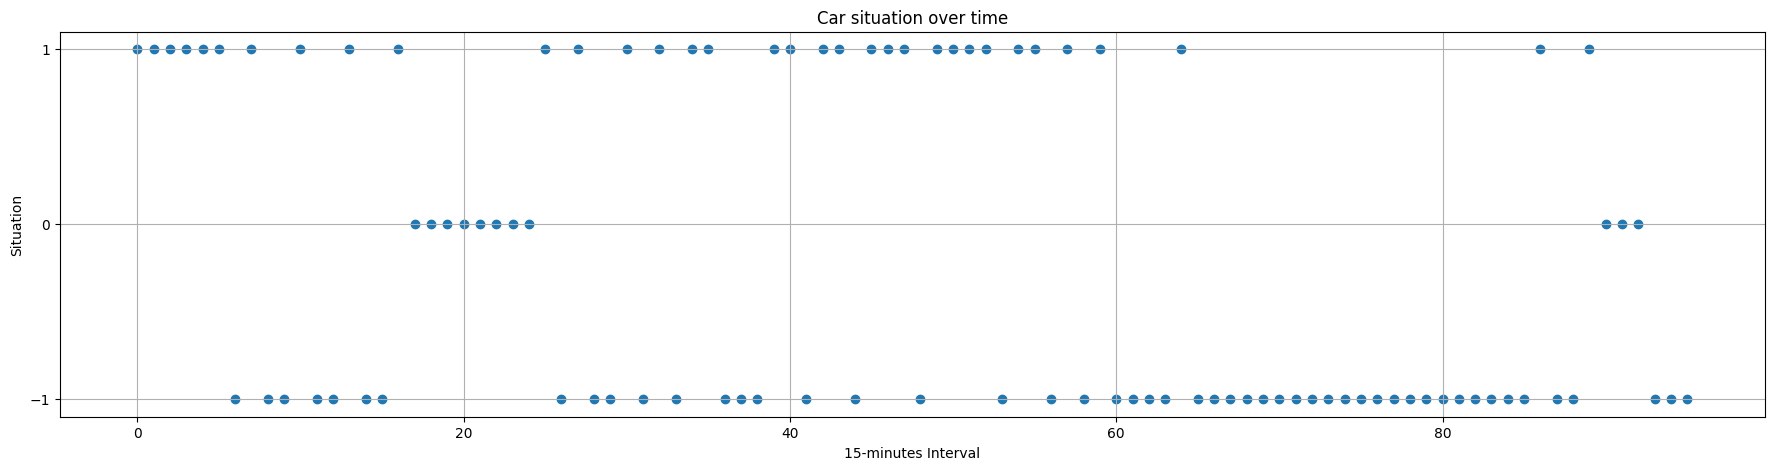

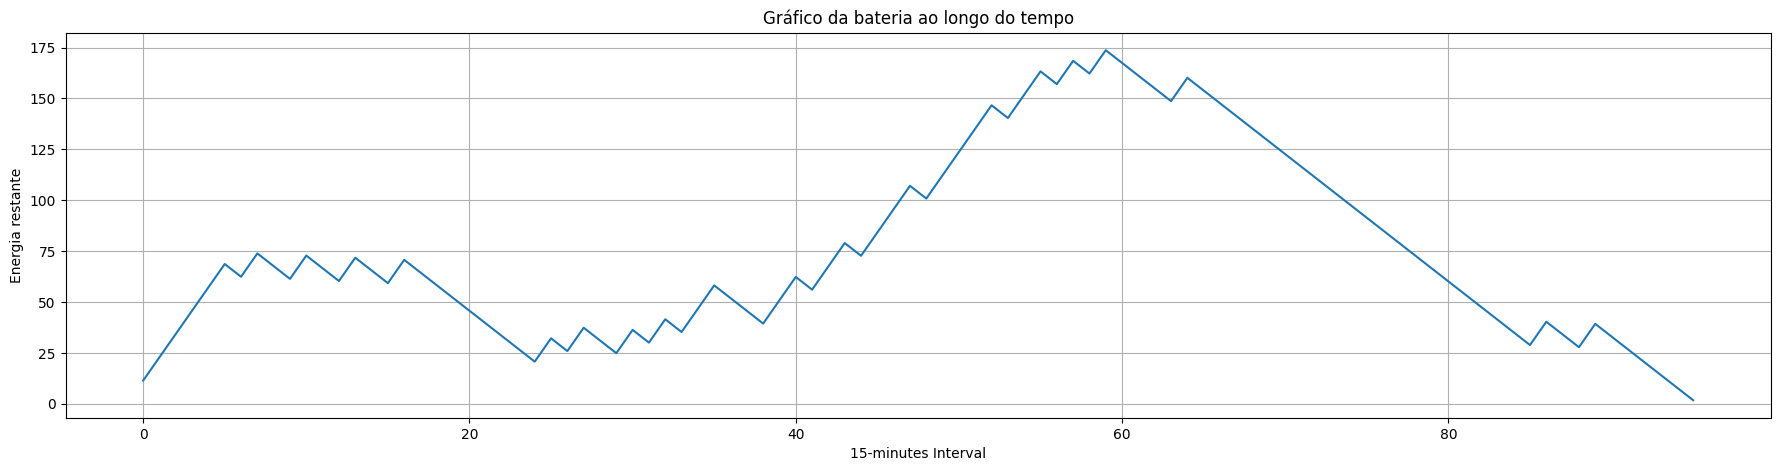

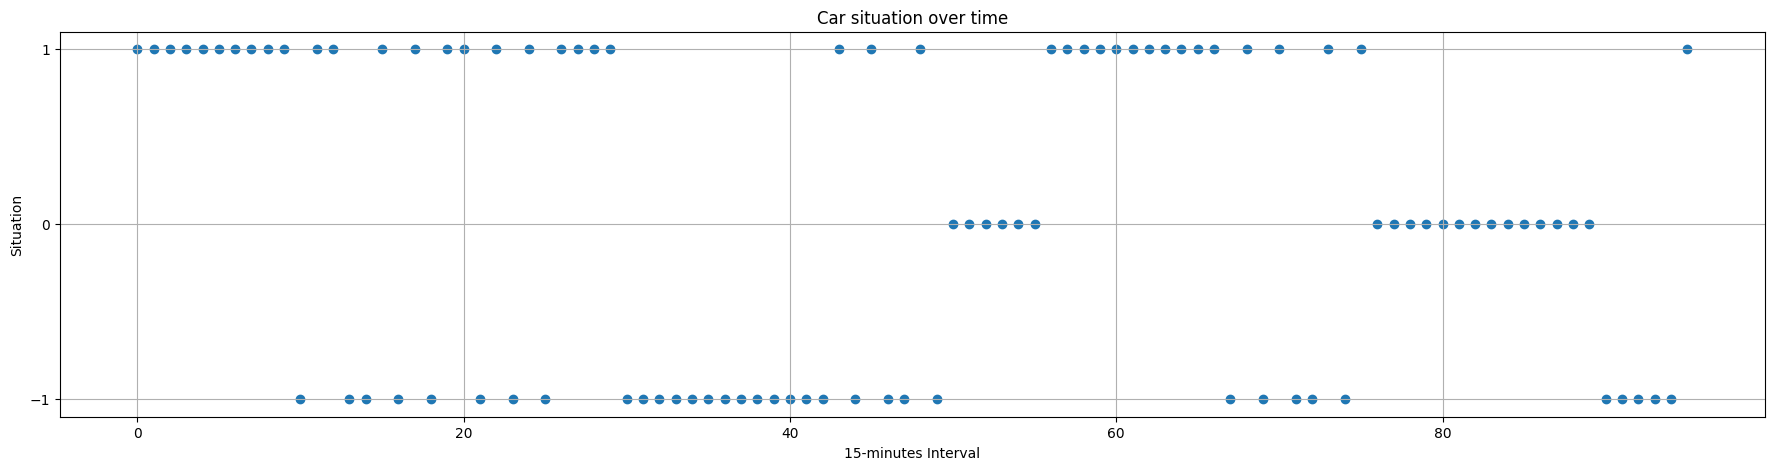

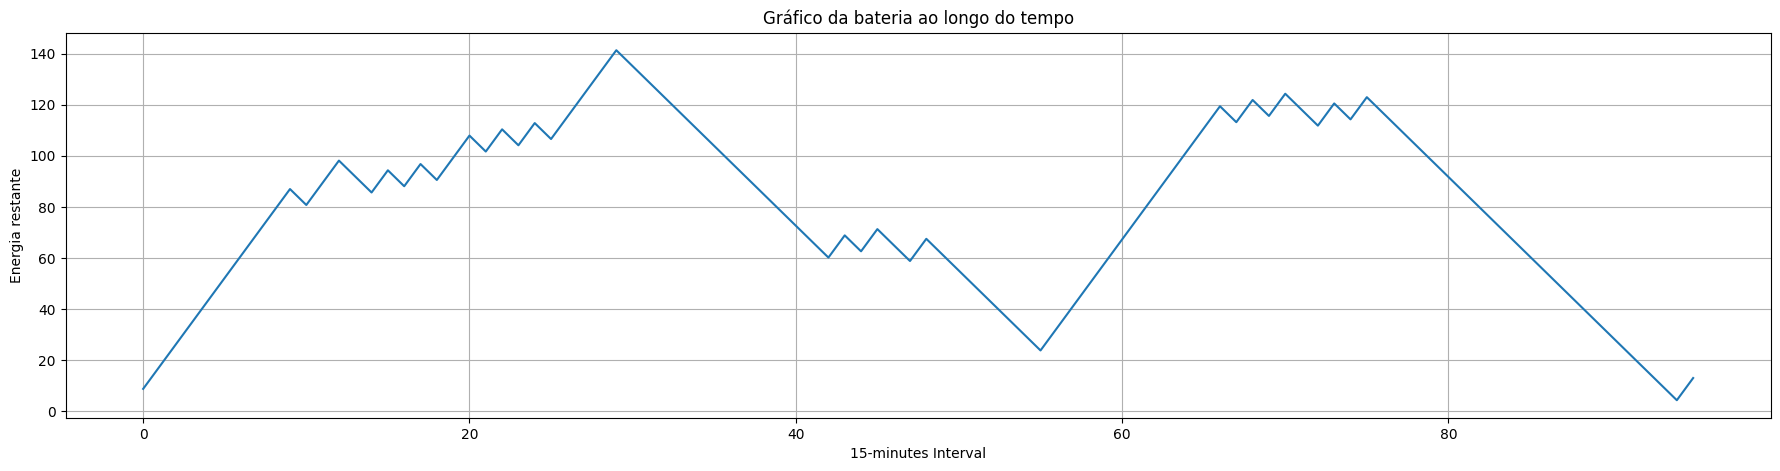

In [356]:
for car_states, car in zip(separated_cars_state, cars):
    plot_car_states(car_states)
    car_energy = calculate_car_energy(car_states, car)
    plot_linear(
        car_energy, "Gráfico da bateria ao longo do tempo", "15-minutes Interval", "Energia restante"
    )

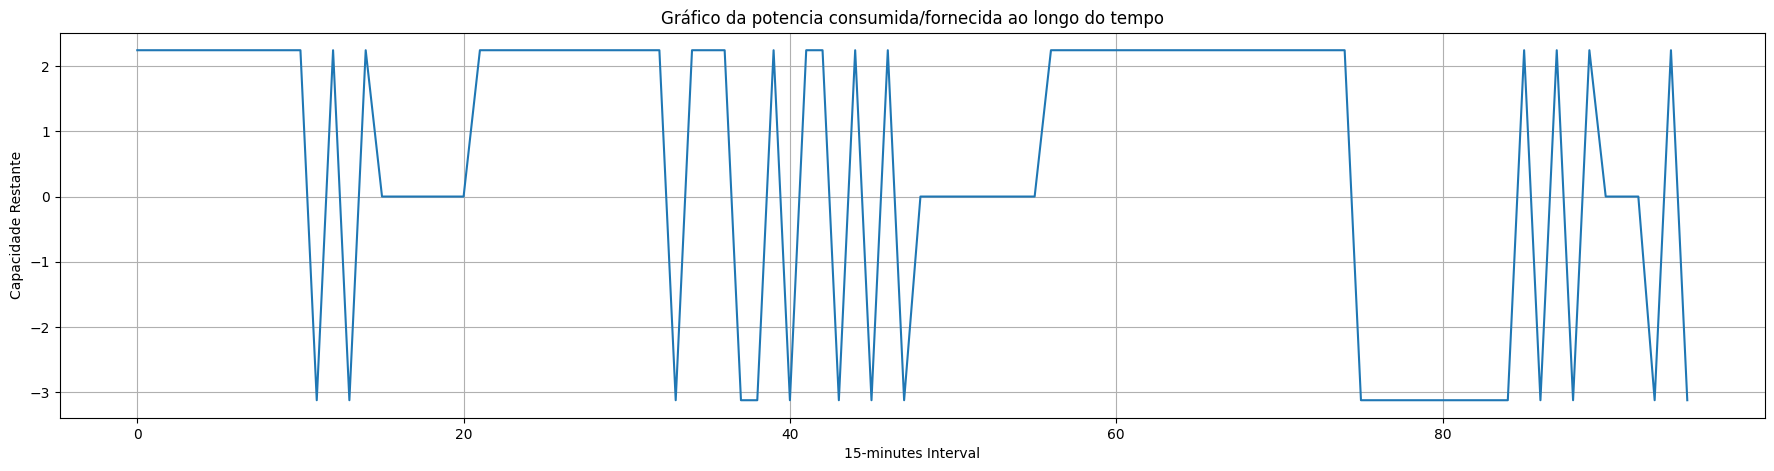

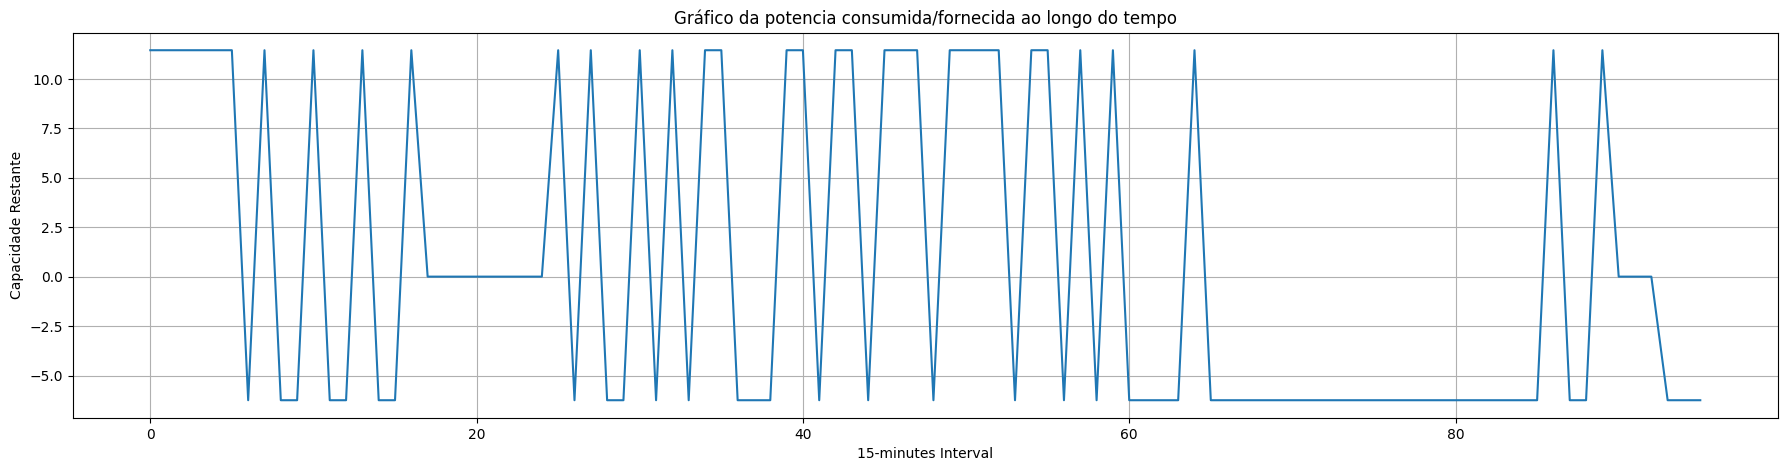

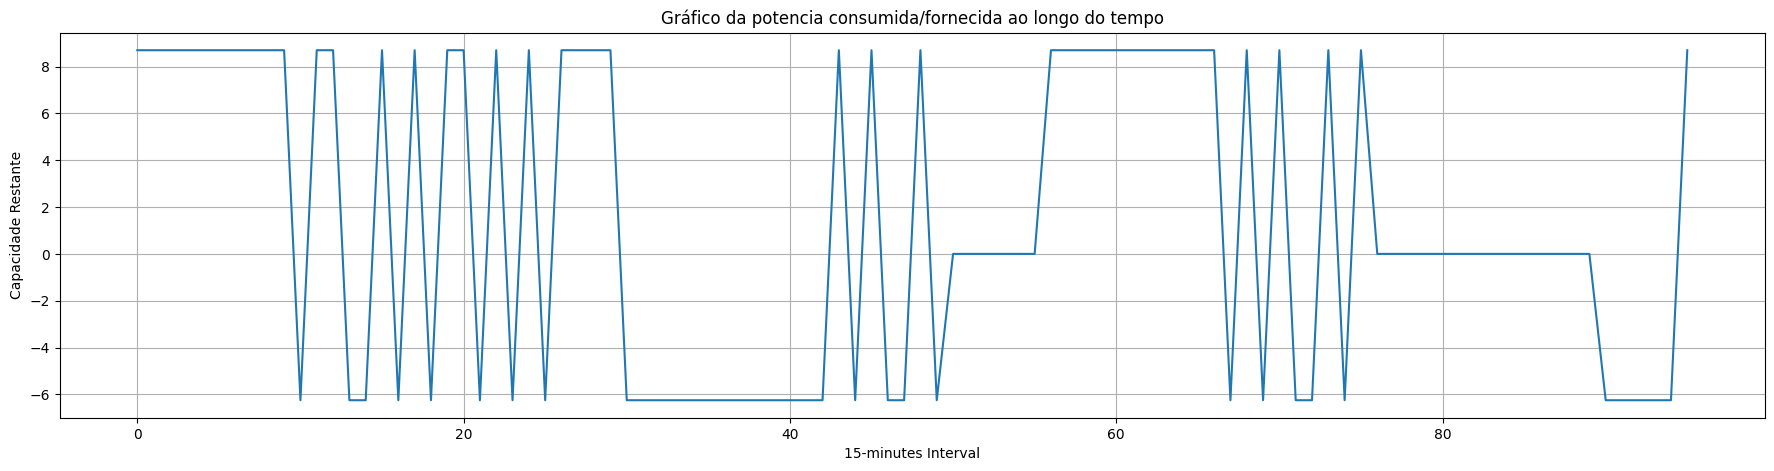

In [357]:
cars_power = [
    calculate_car_power(car_states, car)
    for car_states, car in zip(separated_cars_state, cars)
]

for power in cars_power:
    plot_linear(
        power,
        "Gráfico da potencia consumida/fornecida ao longo do tempo",
        "15-minutes Interval",
        "Capacidade Restante",
    )

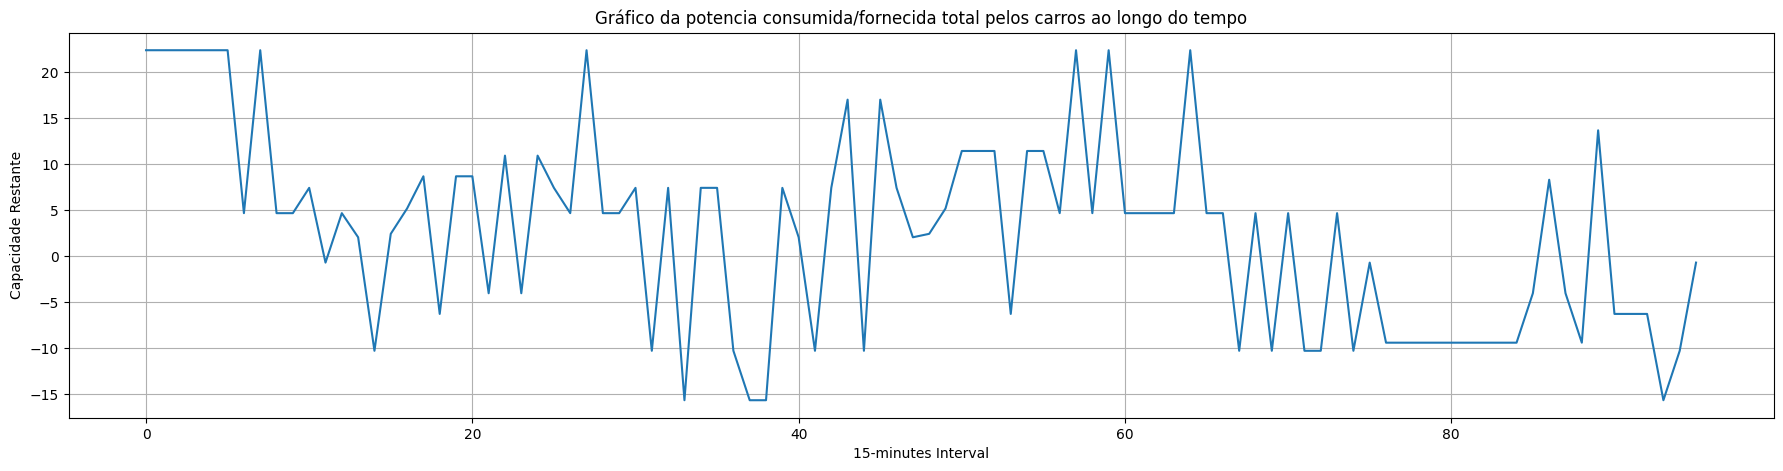

In [358]:
total_cars_power = np.sum(cars_power, axis=0)

plot_linear(
    total_cars_power,
    "Gráfico da potencia consumida/fornecida total pelos carros ao longo do tempo",
    "15-minutes Interval",
    "Capacidade Restante",
)

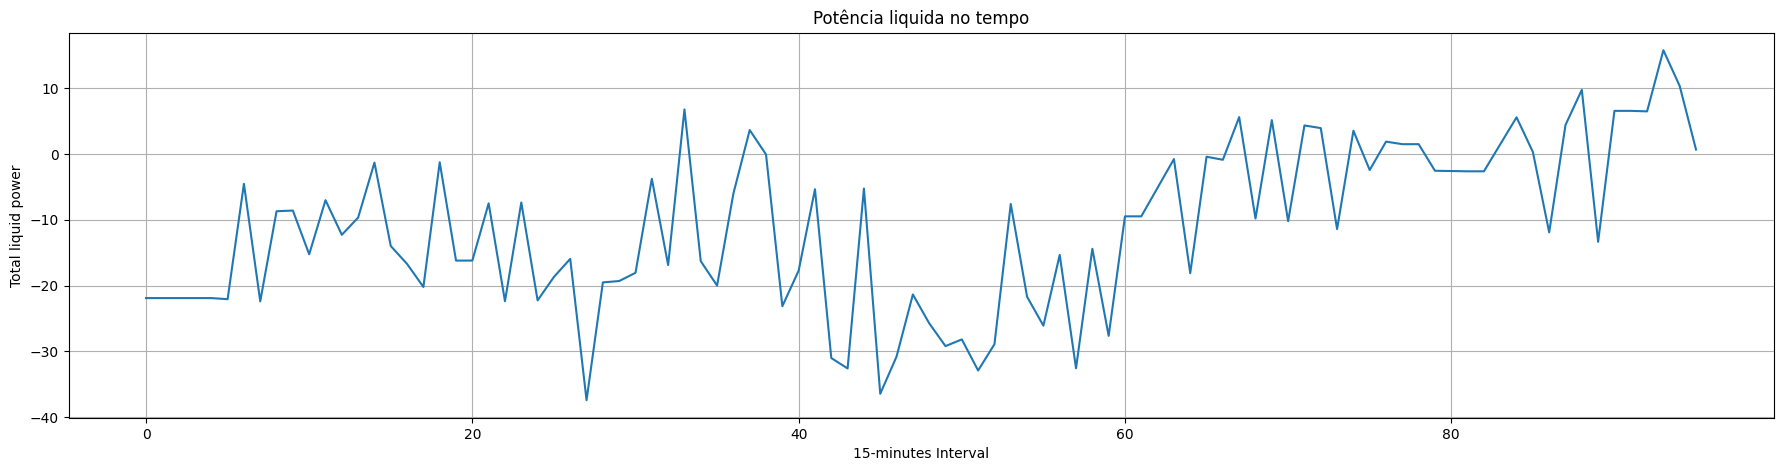

In [359]:
total_liquid_power = generated_power - products_demand - total_cars_power

plot_linear(
    total_liquid_power,
    "Potência liquida no tempo",
    "15-minutes Interval",
    "Total liquid power",
)

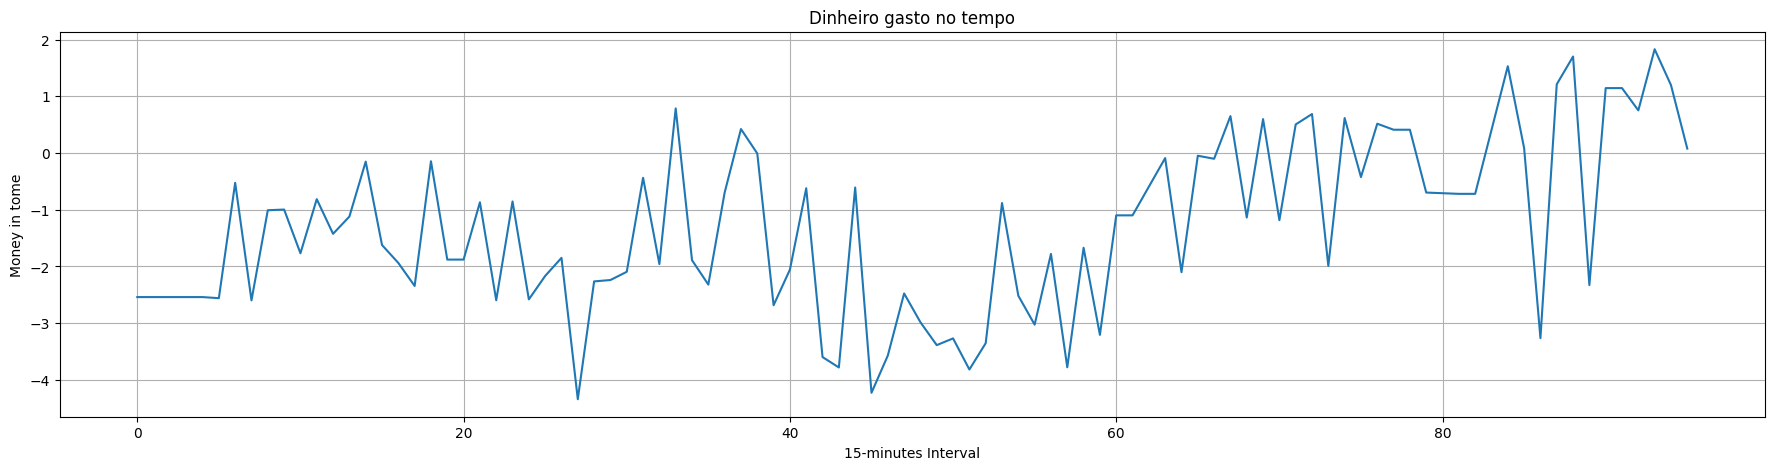

In [360]:
money_in_time = total_liquid_power * energy_cost

plot_linear(
    money_in_time,
    "Dinheiro gasto no tempo",
    "15-minutes Interval",
    "Money in tome",
)

In [361]:
total_money_cost = np.sum(money_in_time)
-total_money_cost.tolist()

123.59938950083306